In [376]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from tensorflow import keras as k
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tscv import GapKFold
import keras_tuner as kt
import shap

Import the datasets with: hourly prices for close, high, low and normalized (dividing by the exchange supply) exchange in and out-flows 

In [506]:
#import data
btc_data = pd.read_csv(r'data\btc_daily_data_NET_vol.csv')
btc_data.index = btc_data['date']
btc_data = btc_data.drop(['date', 'Unnamed: 0'], 1)
eth_data = pd.read_csv(r'data\eth_daily_data_NET_vol.csv')
eth_data.index = eth_data['date']
eth_data = eth_data.drop(['date', 'Unnamed: 0'], 1)

eth_data.head()

,binance.NET,bitfinex.NET,bitstamp.NET,bittrex.NET,gemini.NET,huobi.NET,kraken.NET,poloniex.NET,close,high,low,high-low,volume,weekly_vol
date,,,,,,,,,,,,,,
2016-07-04,0.0,0.001032,0.0,0.003314,0.000738,0.0,0.048725,0.008249,11.38,12.13,11.280,0.850,907110.0,0.243077
2016-07-05,0.0,-0.006775,0.0,0.043815,0.006006,0.0,-0.010510,-0.011091,10.45,11.41,8.976,2.434,961670.0,0.247705
2016-07-06,0.0,0.020904,0.0,0.023380,0.006875,0.0,0.000916,-0.010402,10.43,11.11,10.210,0.900,1020000.0,0.272374
2016-07-07,0.0,0.004137,0.0,0.015449,0.009189,0.0,0.002469,-0.016655,10.03,10.31,9.529,0.781,1510000.0,0.332138
2016-07-08,0.0,0.018151,0.0,-0.000825,0.007478,0.0,0.000782,-0.001680,11.27,11.64,10.300,1.340,1200000.0,0.336190


In [359]:

def split_dataset(dataset, prices, n_steps, train_percentage=0.8, input_scaler=None, output_scaler=None):
	## 'dataset' and 'prices' are arrays
	# Splits a multivariate dataset ('dataset') into samples of size 'n_steps', 
	# flattens the resulting input samples and associates the corresponding output from 'prices',
	# divides the dataset in train and test data using 'train_percentage',
	# if 'input_scaler' and 'output_scaler' are not None: 
	# scales the resulting train and test data base on the train data statistics
	
	X, y = list(), list()
	for i in range(len(dataset)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix >= len(dataset):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = dataset[i:end_ix, :], prices[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	
	X, y = np.array(X), np.array(y)
	# flatten input
	n_input = X.shape[1] * X.shape[2]
	X = X.reshape((X.shape[0], n_input))
	#divide in train and test data
	n = X.shape[0]
	ix = int(n*train_percentage)
	X_train = X[:ix, :]
	X_test = X[ix:, :]
	y_train = y[:ix]
	y_test = y[ix:]

	## scale inputs
	if input_scaler is not None:
		input_scaler.fit(X_train)
		X_train = input_scaler.transform(X_train)
		X_test = input_scaler.transform(X_test)
    ## scale outputs
	if output_scaler is not None:
        # reshape 1d arrays to 2d arrays
		y_train = y_train.reshape(len(y_train), 1)
		y_test = y_test.reshape(len(y_test), 1)
		output_scaler.fit(y_train)
		y_train = output_scaler.transform(y_train)
		y_test = output_scaler.transform(y_test)
	
	return X_train, X_test, y_train, y_test


BITCOIN

PRICE REGRESSION

Linear regression (Benchmark model):

In [357]:
n_steps = 2

## NO NORMALIZATION ##
#split dataset
X_train, X_test, y_train, y_test = split_dataset(btc_data.values, btc_data['close'], n_steps)

#Linear regression (Benchmark model)
reg = LinearRegression().fit(X_train, y_train)
yhat = reg.predict(X_test)
mse = np.power(y_test-yhat, 2).sum() / len(y_test)

print(r'No normalization, {} time steps: MSE = {}'.format(n_steps, mse))

## MIN-MAX NORMALIZATION ##
#normalize and split data
X_train, X_test, y_train, y_test = split_dataset(btc_data.values, btc_data['close'], n_steps, input_scaler=MinMaxScaler(), output_scaler=MinMaxScaler())

#Linear regression (Benchmark model)
reg = LinearRegression().fit(X_train, y_train)
yhat = reg.predict(X_test)
mse = np.power(y_test-yhat, 2).sum() / len(y_test)

print(r'Min-Max normalization, {} time steps: MSE = {}'.format(n_steps, mse))

## MEAN NORMALIZATION ##
#normalize and split data
X_train, X_test, y_train, y_test = split_dataset(btc_data.values, btc_data['close'], n_steps, input_scaler=StandardScaler(), output_scaler=StandardScaler())
#Linear regression (Benchmark model)
reg = LinearRegression().fit(X_train, y_train)
yhat = reg.predict(X_test)
mse = np.power(y_test-yhat, 2).sum() / len(y_test)

print(r'Mean normalization, {} time steps: MSE = {}'.format(n_steps, mse))


No normalization, 2 time steps: MSE = 2438746.5665070675
Min-Max normalization, 2 time steps: MSE = 0.00687639961005032
Mean normalization, 2 time steps: MSE = 0.17777034721913973


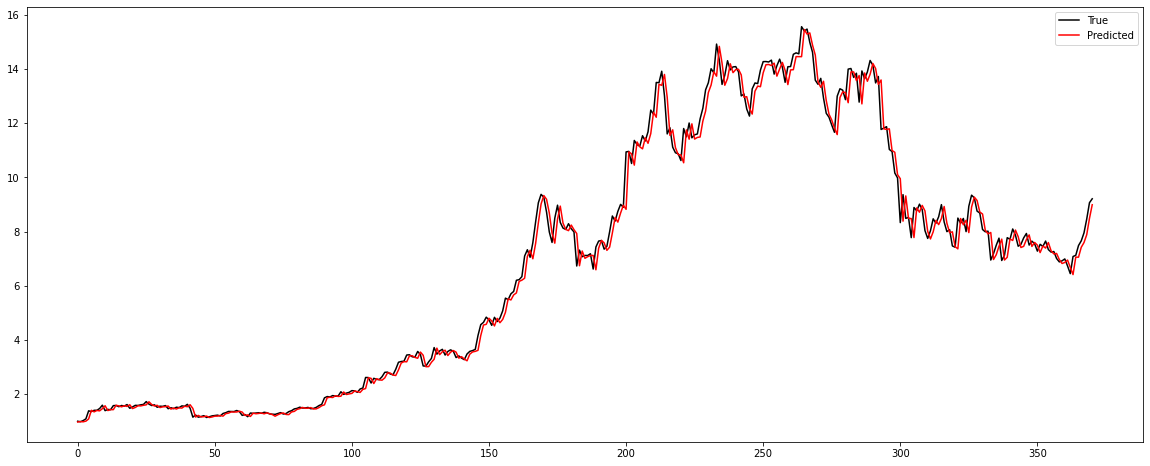

In [358]:
n_steps = 2
#split dataset
X_train, X_test, y_train, y_test = split_dataset(btc_data.values, btc_data['close'], n_steps, input_scaler=StandardScaler(), output_scaler=StandardScaler())

#Linear regression (Benchmark model)
reg = LinearRegression().fit(X_train, y_train)
yhat = reg.predict(X_test)
plt.figure(figsize=(20,8))
plt.plot(y_test, color='black', label='True')
plt.plot(yhat, color = 'red', label='Predicted')
plt.legend()
plt.show()

In [359]:
#Using the previous price as price predictor (Mean normalization)
mse = np.power(y_test[1:]-y_test[:-1], 2).sum() / (len(y_test)-1)
print('Using previous price: MSE = ', mse)

Using previous price: MSE =  0.1760848028329517


In [360]:
## MLP Hyper-parameter tuning ##
def build_model(hp):
    model = k.Sequential()
    model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=526, step=32), 
                activity_regularizer=k.regularizers.l2(hp.Float(f'l2_{i}', min_value=0.001, max_value=0.1, sampling='log'))
            )
        )
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

    model.add(layers.Dense(1, activation="linear"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=Adam(learning_rate=learning_rate), 
        loss='mse',
        metrics=['mean_squared_error']
    )
    return model


#create hp tuner which applies cross-validation
class CVTuner(kt.engine.tuner.Tuner):
  def run_trial(self, trial, x, y, batch_size=50, epochs=1, n_steps=1):
    #optimize number of steps
    cv = GapKFold(n_splits=5, gap_before=n_steps-1, gap_after=n_steps-1)
    val_losses = []
    for train_indices, val_indices in cv.split(x):
      x_train, x_val = x[train_indices], x[val_indices]
      y_train, y_val = y[train_indices], y[val_indices]
      model = self.hypermodel.build(trial.hyperparameters)
      model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)
      val_losses.append(model.evaluate(x_val, y_val))
    self.oracle.update_trial(trial.trial_id, {'val_loss': np.mean(val_losses)})
    #self.save_model(trial.trial_id, model)

tuner = CVTuner(
  hypermodel=build_model,
  oracle=kt.oracles.BayesianOptimization(
    objective='val_loss',
    max_trials=100),
  overwrite=True,
  directory='MLP_price_daily',
  project_name='MLP_price_daily_training')

n_steps=2
X_cv, X_test, y_cv, y_test = split_dataset(btc_data.values, btc_data['close'], n_steps, input_scaler=StandardScaler(), output_scaler=StandardScaler())
tuner.search(X_cv, y_cv, batch_size=50, epochs=30, n_steps=n_steps)

Trial 50 Complete [00h 00m 14s]
val_loss: 0.07688834378495812

Best val_loss So Far: 0.0404481247998774
Total elapsed time: 00h 13m 05s
INFO:tensorflow:Oracle triggered exit


In [361]:
tuner.results_summary()

Results summary
Results in MLP_price_daily\MLP_price_daily_training
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
num_layers: 1
units_0: 16
l2_0: 0.001
lr: 0.01
units_1: 320
l2_1: 0.011273242702608835
units_2: 16
l2_2: 0.1
Score: 0.0404481247998774
Trial summary
Hyperparameters:
num_layers: 1
units_0: 320
l2_0: 0.001
lr: 0.01
units_1: 224
l2_1: 0.037829935643081083
units_2: 16
l2_2: 0.001
Score: 0.0550179734826088
Trial summary
Hyperparameters:
num_layers: 1
units_0: 16
l2_0: 0.001
lr: 0.01
units_1: 304
l2_1: 0.001
units_2: 16
l2_2: 0.001
Score: 0.05757355596870184
Trial summary
Hyperparameters:
num_layers: 1
units_0: 16
l2_0: 0.001
lr: 0.01
units_1: 16
l2_1: 0.001
units_2: 320
l2_2: 0.1
Score: 0.06133822333067655
Trial summary
Hyperparameters:
num_layers: 1
units_0: 176
l2_0: 0.001
lr: 0.01
units_1: 160
l2_1: 0.014854239081224664
units_2: 160
l2_2: 0.010280946518975717
Score: 0.06695640552788973
Trial summary
Hyperparameters:
num_lay

In [362]:
#Best MLP
n_steps = 2

#split data
X_train, X_test, y_train, y_test = split_dataset(btc_data.values, btc_data['close'], n_steps, input_scaler=StandardScaler(), output_scaler=StandardScaler())
#model definition
model = k.Sequential()
model.add(layers.Dense(16, input_dim=X_train.shape[1], activity_regularizer=k.regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU())
model.add(layers.Dense(1, activation="linear"))
learning_rate = 0.01
model.compile(optimizer=Adam(learning_rate=learning_rate), 
              loss='mse',
              metrics=['mean_squared_error']
             )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.000001, verbose=1)
history = model.fit(X_train, y_train, 
                    epochs = 50, 
                    batch_size = 64,
                    verbose=1,
                    validation_data=(X_test, y_test))

Epoch 1/50
24/24 [==============================] - 1s 6ms/step - loss: 0.2515 - mean_squared_error: 0.2170 - val_loss: 4.7912 - val_mean_squared_error: 4.2241
Epoch 2/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0997 - mean_squared_error: 0.0612 - val_loss: 4.0270 - val_mean_squared_error: 3.4023
Epoch 3/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0738 - mean_squared_error: 0.0431 - val_loss: 1.0794 - val_mean_squared_error: 0.5183
Epoch 4/50
24/24 [==============================] - 0s 2ms/step - loss: 0.0630 - mean_squared_error: 0.0391 - val_loss: 0.8073 - val_mean_squared_error: 0.2841
Epoch 5/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0570 - mean_squared_error: 0.0375 - val_loss: 0.8847 - val_mean_squared_error: 0.3856
Epoch 6/50
24/24 [==============================] - 0s 3ms/step - loss: 0.0682 - mean_squared_error: 0.0509 - val_loss: 1.0405 - val_mean_squared_error: 0.5677
Epoch 7/50
24/24 [======================

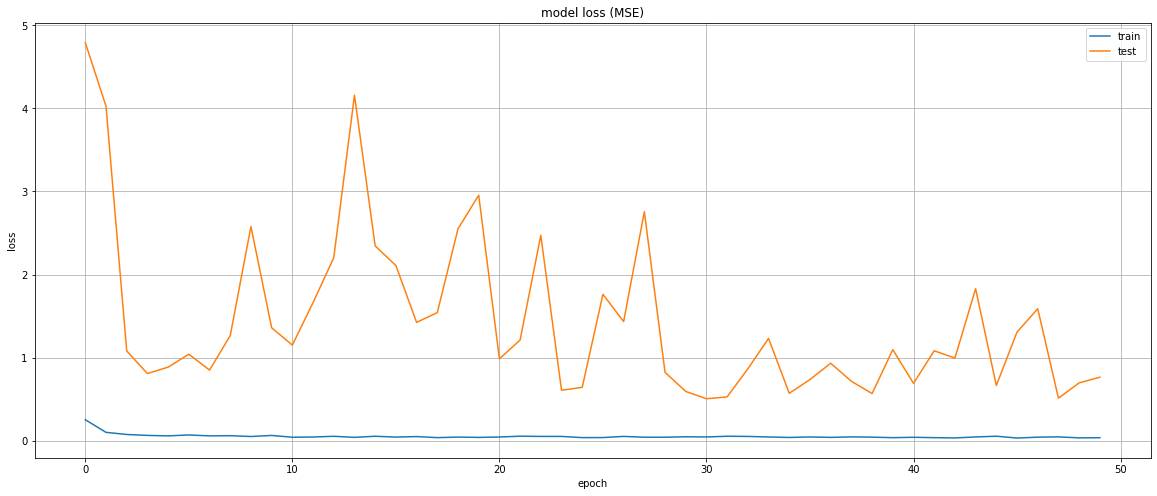

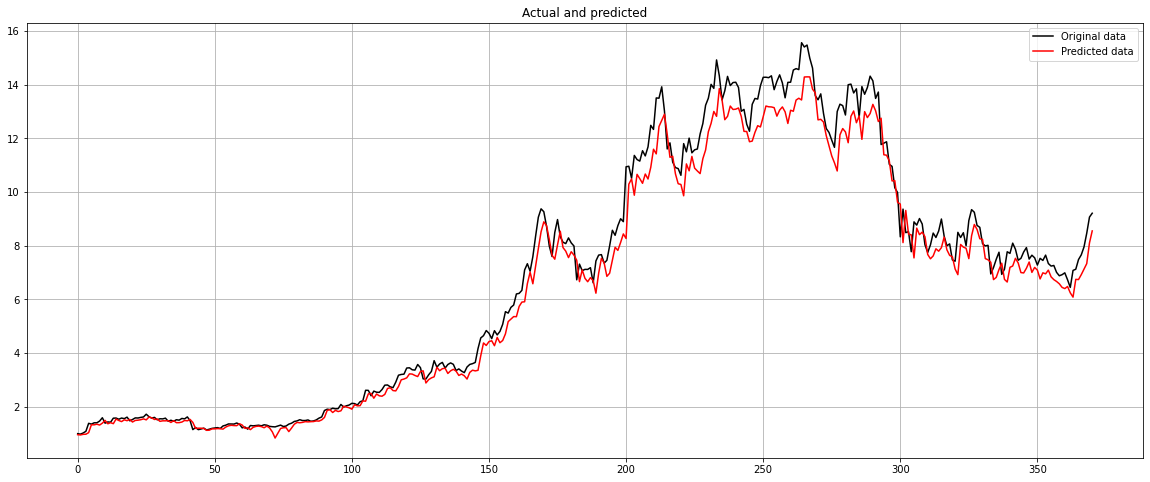

Test MSE =  0.47320374761748785


In [364]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid(True)
plt.title('model loss (MSE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()
pred = model.predict(np.array(X_test))
original = y_test
predicted = pred
plt.figure(figsize=(20,8))
plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='red', label = 'Predicted data')
plt.grid(True)
plt.legend(loc='best')
plt.title('Actual and predicted')
plt.show()
test_mse = np.mean(np.power(y_test-pred, 2))
print('Test MSE = ', test_mse)

RETURNS REGRESSION


In [360]:
#compute returns 
log_ret = np.log(btc_data['close'].values[1:] / btc_data['close'].values[:-1])
log_ret_high = np.log(btc_data['high'].values[1:] / btc_data['close'].values[:-1])
log_ret_low = np.log(btc_data['low'].values[1:] / btc_data['close'].values[:-1])

btc_data_ret = pd.DataFrame(data=btc_data.values[1:, :], columns = btc_data.columns, index=btc_data.index[1:])
btc_data_ret['close'] = log_ret
btc_data_ret['high'] = log_ret_high
btc_data_ret['low'] = log_ret_low


In [361]:
btc_data_ret

,binance.NET,bitfinex.NET,bitmex.NET,bitstamp.NET,bittrex.NET,gemini.NET,huobi.NET,kraken.NET,poloniex.NET,close,high,low,high-low,volume,weekly_vol
date,,,,,,,,,,,,,,,
2016-07-05,0.000000,-0.011358,-0.046352,-0.005179,-0.000648,-0.001491,0.030021,-0.003803,0.030980,-0.017165,0.005951,-0.026794,21.88,66150.0,7.634982
2016-07-06,0.000000,0.000691,-0.015311,0.005517,0.007162,-0.002760,0.078390,-0.010756,-0.013494,0.013514,0.021937,-0.002157,16.15,64870.0,9.708395
2016-07-07,0.000000,0.013277,-0.115734,-0.007600,-0.002311,-0.038045,-0.025930,0.000635,-0.008824,-0.057281,0.005175,-0.106154,71.24,118340.0,8.003366
2016-07-08,0.000000,0.111602,-0.017591,-0.005359,0.021593,0.008810,0.029312,0.007042,0.002646,0.042424,0.043405,-0.008029,33.26,97460.0,8.281091
2016-07-09,0.000000,-0.040398,0.005818,0.003881,-0.065948,0.015342,0.003079,0.005388,-0.003893,-0.016659,0.001071,-0.065627,42.81,77480.0,7.964403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-24,-0.000504,-0.001567,-0.001019,0.001117,-0.001021,0.000317,-0.000964,-0.004108,0.002328,0.018983,0.025878,-0.006228,1090.66,63910.0,370.044137
2021-07-25,-0.008142,-0.000872,-0.003887,0.004664,-0.001471,0.001484,-0.011410,-0.005160,0.002814,0.031225,0.031584,-0.011447,1490.27,99270.0,344.833062
2021-07-26,-0.002849,-0.008270,0.003795,0.004621,-0.012316,0.007896,0.009216,-0.002045,-0.006142,0.052314,0.136769,-0.002822,5283.61,67380.0,453.678573


In [362]:
for n_steps in range(1, 5):

    ## NO NORMALIZATION ##
    #split dataset
    X_train, X_test, y_train, y_test = split_dataset(btc_data_ret.values, btc_data_ret['close'], n_steps, train_percentage=0.8)

    #Linear regression (Benchmark model)
    reg = LinearRegression().fit(X_train, y_train)
    yhat = reg.predict(X_test)
    mse = np.power(y_test-yhat, 2).sum() / len(y_test)

    print(r'No normalization, {} time steps: MSE = {}'.format(n_steps, mse))

    ## MIN-MAX NORMALIZATION ##
    #normalize and split data
    X_train, X_test, y_train, y_test = split_dataset(btc_data_ret.values, btc_data_ret['close'], n_steps, train_percentage=0.8, input_scaler=MinMaxScaler(), output_scaler=MinMaxScaler())

    #Linear regression (Benchmark model)
    reg = LinearRegression().fit(X_train, y_train)
    yhat = reg.predict(X_test)
    mse = np.power(y_test-yhat, 2).sum() / len(y_test)

    print(r'Min-Max normalization, {} time steps: MSE = {}'.format(n_steps, mse))

    ## MEAN NORMALIZATION ##
    #normalize and split data
    X_train, X_test, y_train, y_test = split_dataset(btc_data_ret.values, btc_data_ret['close'], n_steps, train_percentage=0.8, input_scaler=StandardScaler(), output_scaler=StandardScaler())

    #Linear regression (Benchmark model)
    reg = LinearRegression().fit(X_train, y_train)
    yhat = reg.predict(X_test)
    mse = np.power(y_test-yhat, 2).sum() / len(y_test)

    print(r'Mean normalization, {} time steps: MSE = {}'.format(n_steps, mse)+'\n')


No normalization, 1 time steps: MSE = 0.0018173887479631808
Min-Max normalization, 1 time steps: MSE = 0.0036302026889398595
Mean normalization, 1 time steps: MSE = 1.0126530329731167

No normalization, 2 time steps: MSE = 0.0023886190228941556
Min-Max normalization, 2 time steps: MSE = 0.004771225315832158
Mean normalization, 2 time steps: MSE = 1.3301126371046896

No normalization, 3 time steps: MSE = 0.0026210476418583486
Min-Max normalization, 3 time steps: MSE = 0.005235497473230773
Mean normalization, 3 time steps: MSE = 1.4604759415088602

No normalization, 4 time steps: MSE = 0.0028192044633307753
Min-Max normalization, 4 time steps: MSE = 0.005631312306252883
Mean normalization, 4 time steps: MSE = 1.5708042362354275



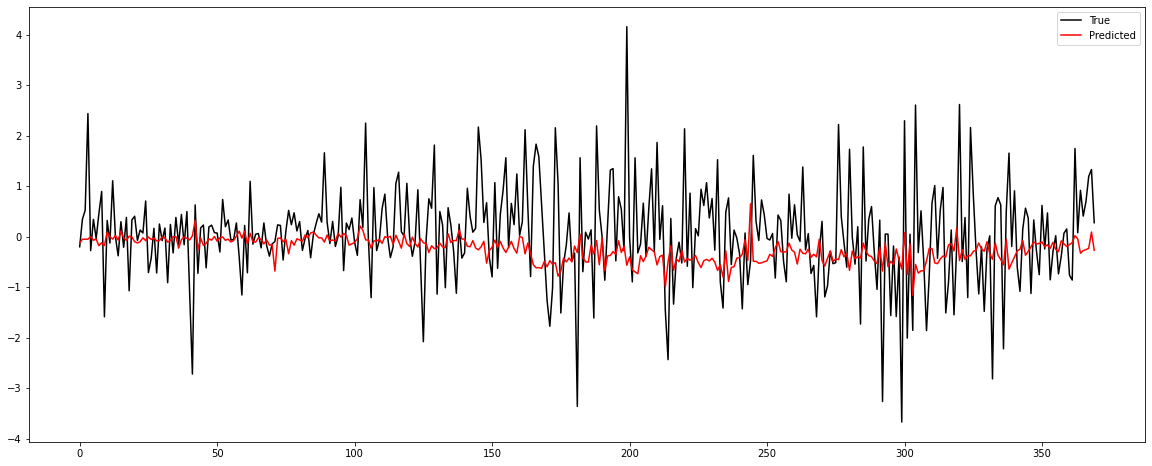

In [363]:
n_steps = 1
#split dataset
X_train, X_test, y_train, y_test = split_dataset(btc_data_ret.values, btc_data_ret['close'], n_steps, train_percentage=0.8, input_scaler=StandardScaler(), output_scaler=StandardScaler())

#Linear regression (Benchmark model)
reg = LinearRegression().fit(X_train, y_train)
yhat = reg.predict(X_test)
plt.figure(figsize=(20,8))
plt.plot(y_test, color='black', label='True')
plt.plot(yhat, color = 'red', label='Predicted')
plt.legend()
plt.show()

In [364]:
#Using the previous return as return predictor (No normalization)
X_train, X_test, y_train, y_test = split_dataset(btc_data_ret.values, btc_data_ret['close'], n_steps)
mse = np.power(y_test[1:]-y_test[:-1], 2).sum() / (len(y_test)-1)
print('Using previous return: MSE = ', mse)

Using previous return: MSE =  0.00355038401054093


In [216]:
## MLP Hyper-parameter tuning ##
def build_model(hp):
    model = k.Sequential()
    model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(1):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int('units', min_value=16, max_value=320, step=16), 
                activity_regularizer=k.regularizers.l1(hp.Float('l1', min_value=0.1, max_value=1, step=0.1))
            )
        )
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1, activation="linear"))
    learning_rate = 0.005
    model.compile(
        optimizer=Adam(learning_rate=learning_rate), 
        loss='mse',
        metrics=['mean_squared_error']
    )
    return model


#create hp tuner which applies cross-validation
class CVTuner(kt.engine.tuner.Tuner):
  def run_trial(self, trial, x, y, batch_size=50, epochs=1, n_steps=1):
    #optimize number of steps
    cv = GapKFold(n_splits=5, gap_before=n_steps-1, gap_after=n_steps-1)
    val_losses = []
    for train_indices, val_indices in cv.split(x):
      x_train, x_val = x[train_indices], x[val_indices]
      y_train, y_val = y[train_indices], y[val_indices]
      model = self.hypermodel.build(trial.hyperparameters)
      model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)
      val_losses.append(model.evaluate(x_val, y_val))
    self.oracle.update_trial(trial.trial_id, {'val_loss': np.mean(val_losses)})
    #self.save_model(trial.trial_id, model)



results_summaries = []
for n_steps in range(1,6):
  results = []
  print('\n -> N_STEPS = ', n_steps)
  print('\nBTC:')
  tuner = CVTuner(
  hypermodel=build_model,
  oracle=kt.oracles.BayesianOptimization(
    objective='val_loss',
    max_trials=50),
  overwrite=True,
  directory='MLP_ret_daily',
  project_name='MLP_ret_daily_training')
  X_cv, X_test, y_cv, y_test = split_dataset(btc_data_ret.values, btc_data_ret['close'], n_steps, train_percentage=0.8, input_scaler=StandardScaler(), output_scaler=StandardScaler())
  tuner.search(X_cv, y_cv, batch_size=64, epochs=30, n_steps=n_steps)
  results += [tuner.get_best_hyperparameters()[0]]
  print('\nETH:')
  tuner = CVTuner(
  hypermodel=build_model,
  oracle=kt.oracles.BayesianOptimization(
    objective='val_loss',
    max_trials=50),
  overwrite=True,
  directory='MLP_ret_daily',
  project_name='MLP_ret_daily_training')
  X_cv, X_test, y_cv, y_test = split_dataset(eth_data_ret.values, eth_data_ret['close'], n_steps, train_percentage=0.8, input_scaler=StandardScaler(), output_scaler=StandardScaler())
  tuner.search(X_cv, y_cv, batch_size=64, epochs=30, n_steps=n_steps)
  results += [tuner.get_best_hyperparameters()[0]]
  results_summaries.append(results)

Trial 50 Complete [00h 00m 11s]
val_loss: 1.2968833982944488

Best val_loss So Far: 1.2250291049480437
Total elapsed time: 00h 10m 29s
INFO:tensorflow:Oracle triggered exit


In [217]:
results_summaries

[[<keras_tuner.engine.hyperparameters.HyperParameters at 0x23f7b5628b0>,

In [414]:
#Best MLP

def build_and_fit_model(n_steps, btc_data_ret):
    #split data
    X_train, X_test, y_train, y_test = split_dataset(btc_data_ret.values, btc_data_ret['close'], n_steps, train_percentage=0.8, input_scaler=StandardScaler(), output_scaler=StandardScaler())

    #model definition
    model = k.Sequential()
    initializer = k.initializers.GlorotNormal()
    model.add(layers.Dense(120, input_dim=X_train.shape[1], activity_regularizer=k.regularizers.l1(0.8), kernel_initializer=initializer))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation="linear"))
    learning_rate = 0.005
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                loss='mse',
                metrics=['mean_squared_error']
                )
    #fit model
    history = model.fit(X_train, y_train, 
                        epochs = 100, 
                        batch_size = 50, 
                        verbose=1,
                        shuffle=False,
                        validation_data=(X_test, y_test))
    return history, model, X_train, y_train, X_test, y_test

In [415]:
def plot_results(n_steps, model, history, X_test, y_test):
    print('-> N_STEPS = ', n_steps)
    plt.figure(figsize=(20,8))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.grid(True)
    plt.title('model loss (MSE)')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')
    plt.show()
    pred = model.predict(np.array(X_test))
    original = y_test
    predicted = pred
    plt.figure(figsize=(20,8))
    plt.plot(original, color='black', label = 'Original data')
    plt.plot(predicted, color='red', label = 'Predicted data')
    plt.grid(True)
    plt.legend(loc='best')
    plt.title('Actual and predicted')
    plt.show()
    test_mse = np.mean(np.power(y_test-pred, 2))
    print('test MSE = ', test_mse)
    return test_mse
    

Train on 1479 samples, validate on 370 samples
Epoch 1/100
  50/1479 [>.............................] - ETA: 3s - loss: 40.5062 - mean_squared_error: 4.0710

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


1479/1479 [==============================] - 0s 250us/sample - loss: 22.8210 - mean_squared_error: 1.8054 - val_loss: 31.2606 - val_mean_squared_error: 0.9564
Epoch 2/100
1479/1479 [==============================] - 0s 57us/sample - loss: 10.7892 - mean_squared_error: 1.3992 - val_loss: 16.5646 - val_mean_squared_error: 0.9443
Epoch 3/100
1479/1479 [==============================] - 0s 63us/sample - loss: 5.9403 - mean_squared_error: 1.3213 - val_loss: 11.7897 - val_mean_squared_error: 0.9187
Epoch 4/100
1479/1479 [==============================] - 0s 69us/sample - loss: 4.3063 - mean_squared_error: 1.1272 - val_loss: 9.0932 - val_mean_squared_error: 0.9208
Epoch 5/100
1479/1479 [==============================] - 0s 56us/sample - loss: 3.4343 - mean_squared_error: 1.0343 - val_loss: 6.7314 - val_mean_squared_error: 0.9272
Epoch 6/100
1479/1479 [==============================] - 0s 57us/sample - loss: 3.0840 - mean_squared_error: 1.0230 - val_loss: 5.5827 - val_mean_squared_error: 0.922

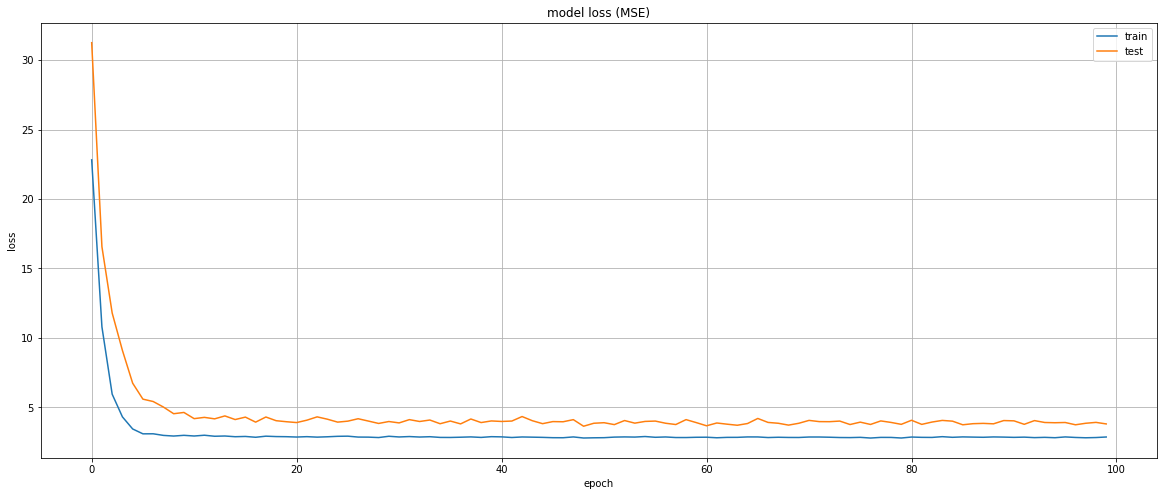

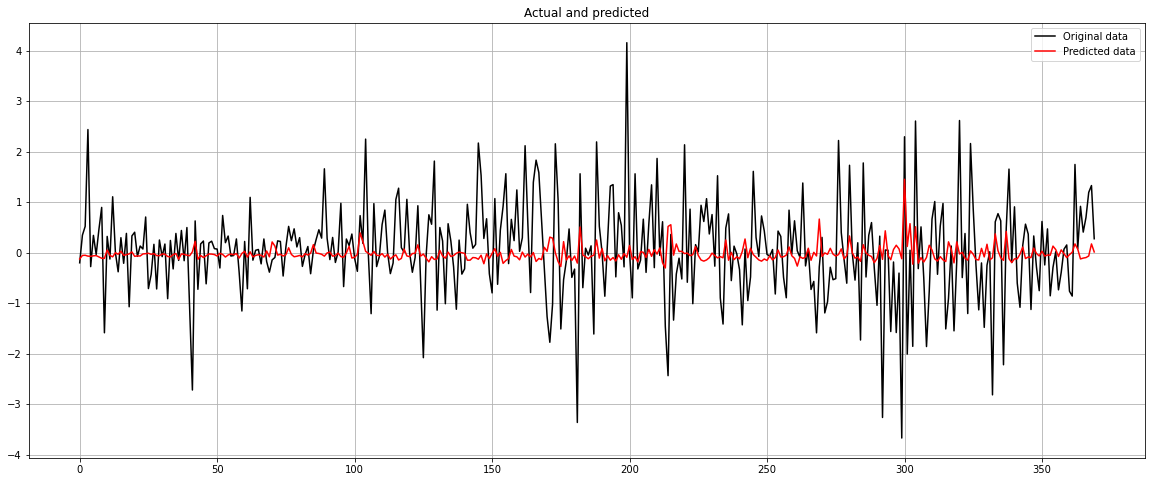

test MSE =  0.904969411945347
Experiments result: test MSE = 0.904969411945347
std error =  0.0


In [416]:
n_steps = 1
n_exp = 1

exp_res = []
for i in range(n_exp):
    history, model, X_train, y_train, X_test, y_test = build_and_fit_model(n_steps, btc_data_ret)
    test_mse = plot_results(n_steps, model, history, X_test, y_test)
    exp_res += [test_mse]
print('Experiments result: test MSE =', np.mean(exp_res))
print('std error = ', np.std(exp_res))

Analyze feature contribution (Shapley Additive Explanation)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


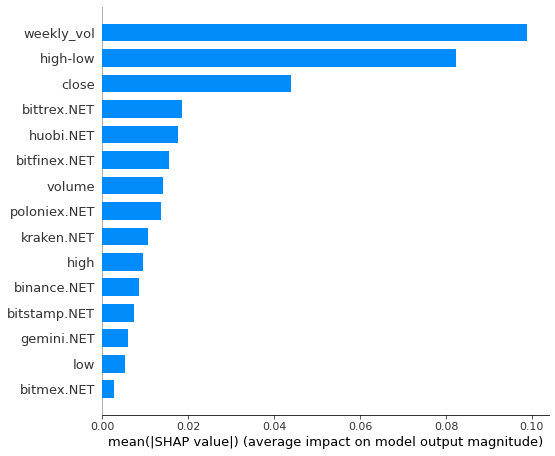

In [417]:
background = X_train
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(X_test, check_additivity=False)
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = btc_data.columns)

In [419]:
shap.initjs()
#force plot
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features = btc_data.columns)

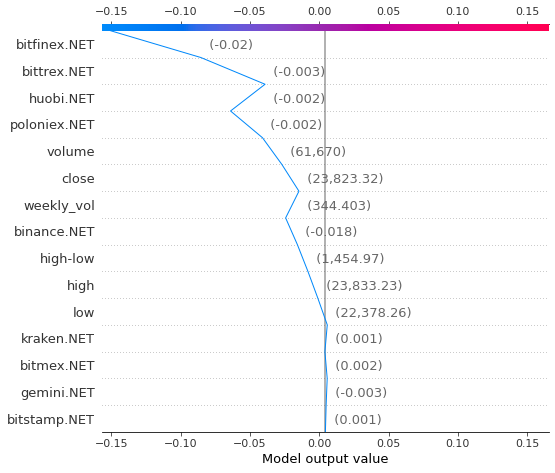

In [420]:
shap.decision_plot(explainer.expected_value[0], shap_values[0][0], features = btc_data.iloc[np.random.choice(len(btc_data_ret)),:], feature_names = btc_data.columns.tolist())

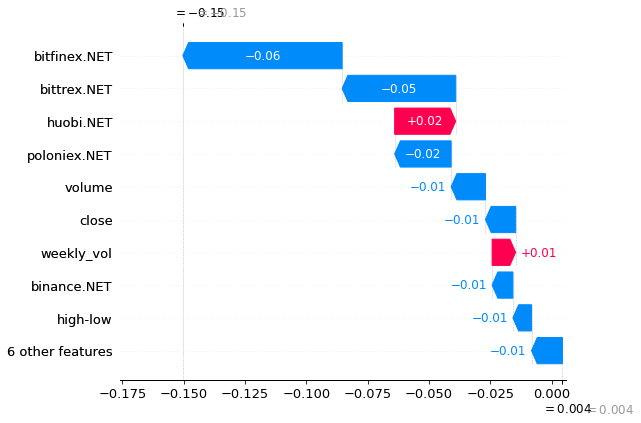

In [422]:
#waterfall plot
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][0], feature_names = btc_data.columns)

ETH

Returns regression

In [507]:
#compute returns 
log_ret = np.log(eth_data['close'].values[1:] / eth_data['close'].values[:-1])
log_ret_high = np.log(eth_data['high'].values[1:] / eth_data['close'].values[:-1])
log_ret_low = np.log(eth_data['low'].values[1:] / eth_data['close'].values[:-1])

eth_data_ret = pd.DataFrame(data=eth_data.values[1:, :], columns = eth_data.columns, index=eth_data.index[1:])
eth_data_ret['close'] = log_ret
eth_data_ret['high'] = log_ret_high
eth_data_ret['low'] = log_ret_low
eth_data_ret.drop('huobi.NET', axis=1, inplace=True)

In [508]:
eth_data_ret

,binance.NET,bitfinex.NET,bitstamp.NET,bittrex.NET,gemini.NET,kraken.NET,poloniex.NET,close,high,low,high-low,volume,weekly_vol
date,,,,,,,,,,,,,
2016-07-05,0.000000,-0.006775,0.000000,0.043815,0.006006,-0.010510,-0.011091,-0.085255,0.002633,-0.237303,2.434,961670.0,0.247705
2016-07-06,0.000000,0.020904,0.000000,0.023380,0.006875,0.000916,-0.010402,-0.001916,0.061244,-0.023234,0.900,1020000.0,0.272374
2016-07-07,0.000000,0.004137,0.000000,0.015449,0.009189,0.002469,-0.016655,-0.039106,-0.011572,-0.090346,0.781,1510000.0,0.332138
2016-07-08,0.000000,0.018151,0.000000,-0.000825,0.007478,0.000782,-0.001680,0.116564,0.148867,0.026563,1.340,1200000.0,0.336190
2016-07-09,0.000000,-0.012871,0.000000,0.002330,-0.000480,0.003965,-0.009359,-0.031548,0.006192,-0.052836,0.650,802780.0,0.228340
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-24,0.001774,0.036152,0.007728,-0.002043,-0.001087,-0.002090,0.016246,0.028024,0.034413,-0.008552,92.520,147790.0,30.268927
2021-07-25,-0.005864,0.002986,0.003197,-0.007367,0.000181,-0.001144,-0.000327,0.003817,0.005060,-0.035751,87.860,196780.0,25.827133
2021-07-26,0.000977,0.041519,0.011512,-0.008664,0.002028,0.003820,0.016407,0.015524,0.102121,-0.008660,254.850,86170.0,30.587465


In [497]:
for n_steps in range(1, 5):

    ## NO NORMALIZATION ##
    #split dataset
    X_train, X_test, y_train, y_test = split_dataset(eth_data_ret.values, eth_data_ret['close'], n_steps, train_percentage=0.8)

    #Linear regression (Benchmark model)
    reg = LinearRegression().fit(X_train, y_train)
    yhat = reg.predict(X_test)
    mse = np.power(y_test-yhat, 2).sum() / len(y_test)

    print(r'No normalization, {} time steps: MSE = {}'.format(n_steps, mse))

    ## MIN-MAX NORMALIZATION ##
    #normalize and split data
    X_train, X_test, y_train, y_test = split_dataset(eth_data_ret.values, eth_data_ret['close'], n_steps, train_percentage=0.8, input_scaler=MinMaxScaler(), output_scaler=MinMaxScaler())

    #Linear regression (Benchmark model)
    reg = LinearRegression().fit(X_train, y_train)
    yhat = reg.predict(X_test)
    mse = np.power(y_test-yhat, 2).sum() / len(y_test)

    print(r'Min-Max normalization, {} time steps: MSE = {}'.format(n_steps, mse))

    ## MEAN NORMALIZATION ##
    #normalize and split data
    X_train, X_test, y_train, y_test = split_dataset(eth_data_ret.values, eth_data_ret['close'], n_steps, train_percentage=0.8, input_scaler=StandardScaler(), output_scaler=StandardScaler())

    #Linear regression (Benchmark model)
    reg = LinearRegression().fit(X_train, y_train)
    yhat = reg.predict(X_test)
    mse = np.power(y_test-yhat, 2).sum() / len(y_test)

    print(r'Mean normalization, {} time steps: MSE = {}'.format(n_steps, mse)+'\n')


No normalization, 1 time steps: MSE = 0.0038914935750873343
Min-Max normalization, 1 time steps: MSE = 0.005652242694832143
Mean normalization, 1 time steps: MSE = 1.1671605813391428

No normalization, 2 time steps: MSE = 0.003916771705075667
Min-Max normalization, 2 time steps: MSE = 0.00568895819691417
Mean normalization, 2 time steps: MSE = 1.173951932489243

No normalization, 3 time steps: MSE = 0.006397589437576279
Min-Max normalization, 3 time steps: MSE = 0.00929947969636148
Mean normalization, 3 time steps: MSE = 1.9168802660018145

No normalization, 4 time steps: MSE = 0.006368718103962408
Min-Max normalization, 4 time steps: MSE = 0.009291963871855628
Mean normalization, 4 time steps: MSE = 1.9324248380366866



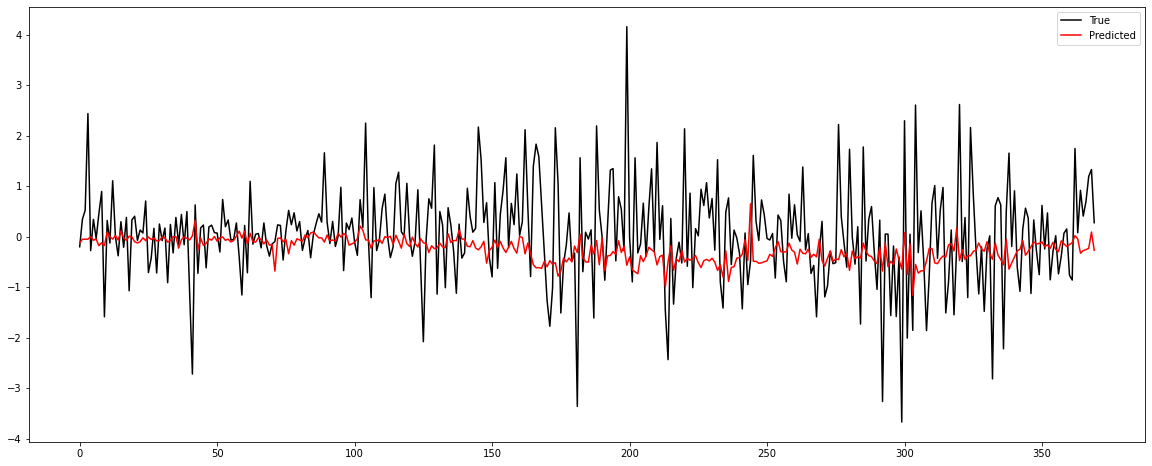

In [498]:
n_steps = 1
#split dataset
X_train, X_test, y_train, y_test = split_dataset(btc_data_ret.values, btc_data_ret['close'], n_steps, train_percentage=0.8, input_scaler=StandardScaler(), output_scaler=StandardScaler())

#Linear regression (Benchmark model)
reg = LinearRegression().fit(X_train, y_train)
yhat = reg.predict(X_test)
plt.figure(figsize=(20,8))
plt.plot(y_test, color='black', label='True')
plt.plot(yhat, color = 'red', label='Predicted')
plt.legend()
plt.show()

In [499]:
#Using the previous return as return predictor (No normalization)
X_train, X_test, y_train, y_test = split_dataset(eth_data_ret.values, btc_data_ret['close'], n_steps)
mse = np.power(y_test[1:]-y_test[:-1], 2).sum() / (len(y_test)-1)
print('Using previous return: MSE = ', mse)

Using previous return: MSE =  0.00355038401054093


In [510]:
#Best MLP

def build_and_fit_model(n_steps, eth_data_ret):
    #split data
    X_train, X_test, y_train, y_test = split_dataset(eth_data_ret.values, eth_data_ret['close'], n_steps, train_percentage=0.8, input_scaler=StandardScaler(), output_scaler=StandardScaler())

    #model definition
    model = k.Sequential()
    initializer = k.initializers.GlorotNormal()
    model.add(layers.Dense(120, input_dim=X_train.shape[1], activity_regularizer=k.regularizers.l1(0.5), kernel_initializer=initializer))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation="linear"))
    learning_rate = 0.001
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                loss='mse',
                metrics=['mean_squared_error']
                )
    #fit model
    history = model.fit(X_train, y_train, 
                        epochs = 100, 
                        batch_size = 50, 
                        verbose=1,
                        shuffle=False,
                        validation_data=(X_test, y_test))
    return history, model, X_train, y_train, X_test, y_test

Train on 1479 samples, validate on 370 samples
Epoch 1/100
1350/1479 [==========================>...] - ETA: 0s - loss: 17.5494 - mean_squared_error: 1.9755

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


1479/1479 [==============================] - 2s 2ms/sample - loss: 16.9006 - mean_squared_error: 1.8930 - val_loss: 55.3430 - val_mean_squared_error: 2.0636
Epoch 2/100
1479/1479 [==============================] - 0s 127us/sample - loss: 14.5383 - mean_squared_error: 1.5195 - val_loss: 49.9035 - val_mean_squared_error: 1.9327
Epoch 3/100
1479/1479 [==============================] - 0s 196us/sample - loss: 12.6550 - mean_squared_error: 1.4377 - val_loss: 44.1412 - val_mean_squared_error: 1.5180
Epoch 4/100
1479/1479 [==============================] - 0s 150us/sample - loss: 11.0538 - mean_squared_error: 1.4340 - val_loss: 39.1450 - val_mean_squared_error: 1.8319
Epoch 5/100
1479/1479 [==============================] - 0s 164us/sample - loss: 9.5514 - mean_squared_error: 1.3196 - val_loss: 33.5778 - val_mean_squared_error: 1.2675
Epoch 6/100
1479/1479 [==============================] - 0s 177us/sample - loss: 8.2438 - mean_squared_error: 1.2235 - val_loss: 29.4566 - val_mean_squared_erro

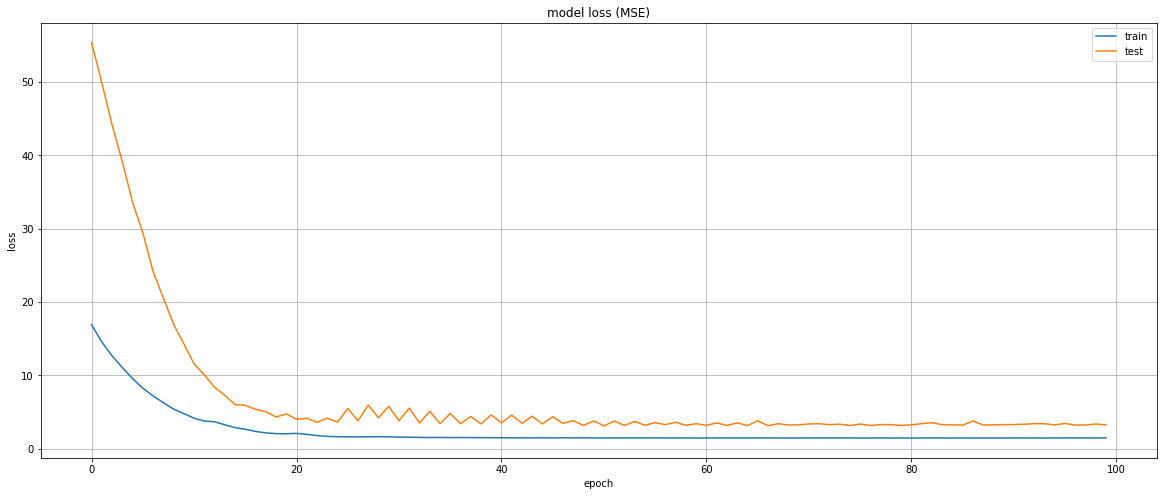

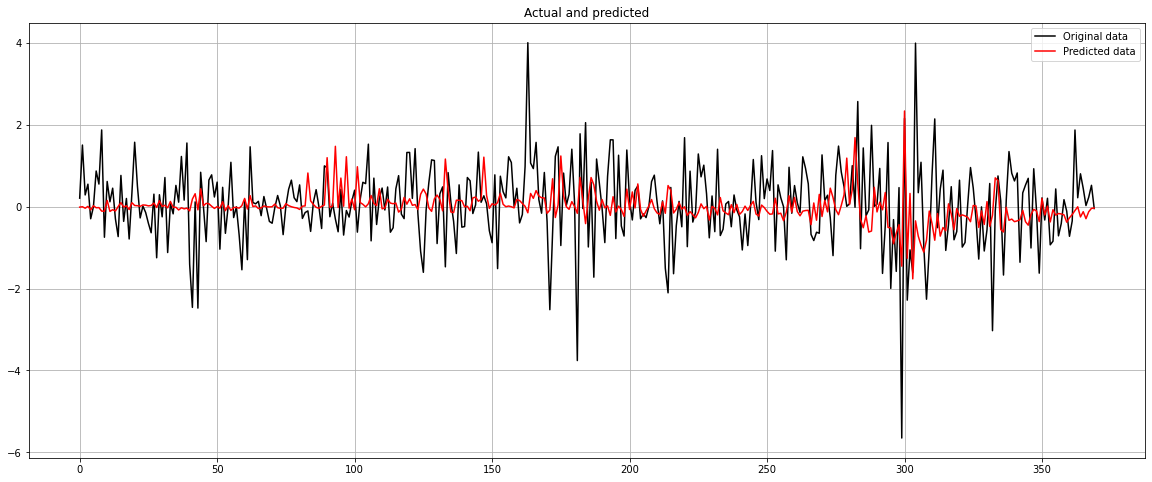

test MSE =  0.9942161875579906
Experiments result: test MSE = 0.9942161875579906
std error =  0.0


In [513]:
n_steps = 1
n_exp = 1

exp_res = []
for i in range(n_exp):
    history, model, X_train, y_train, X_test, y_test = build_and_fit_model(n_steps, eth_data_ret)
    test_mse = plot_results(n_steps, model, history, X_test, y_test)
    exp_res += [test_mse]
print('Experiments result: test MSE =', np.mean(exp_res))
print('std error = ', np.std(exp_res))

Analyze features contribution (Shapley Additive Features)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


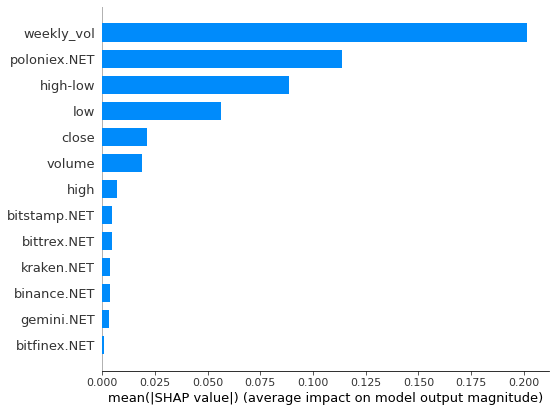

In [516]:
background = X_train
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(X_test, check_additivity=False)
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = eth_data_ret.columns)

In [519]:
shap.initjs()
#force plot
shap.force_plot(explainer.expected_value[0], shap_values[0][np.random.choice(len(eth_data_ret))], features = eth_data_ret.columns)

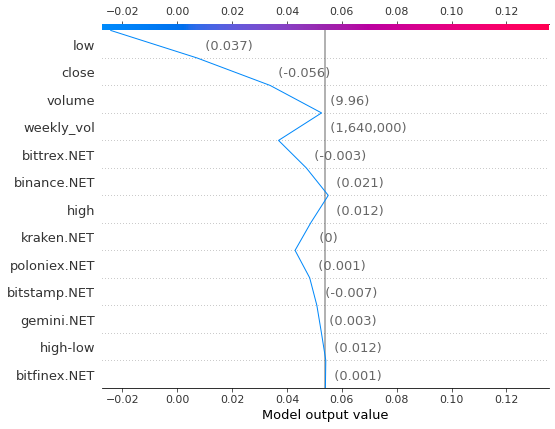

In [522]:
shap.decision_plot(explainer.expected_value[0], shap_values[0][0], features = eth_data.iloc[np.random.choice(len(eth_data_ret)),:], feature_names = eth_data_ret.columns.tolist())

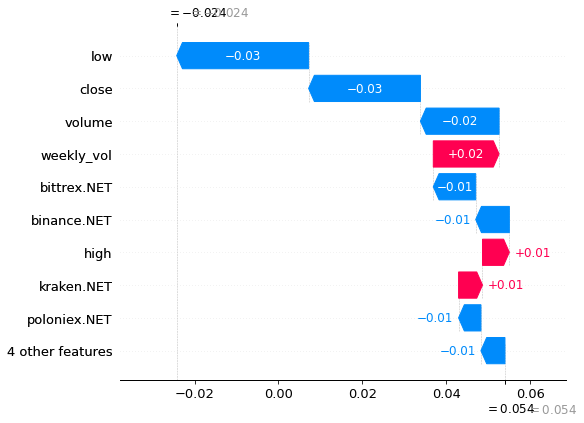

In [525]:
#waterfall plot
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][0], feature_names = eth_data_ret.columns)